In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
%env OPENMC_CROSS_SECTIONS = /home/aulegoup/openmc_config/endfb71_hdf5/cross_sections.xml
import openmc
import os
import numpy as np
from uncertainties import ufloat

env: OPENMC_CROSS_SECTIONS=/home/aulegoup/openmc_config/endfb71_hdf5/cross_sections.xml


# General parameters of the model

<>:167: SyntaxWarning: invalid escape sequence '\g'
<>:167: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_5039/564909897.py:167: SyntaxWarning: invalid escape sequence '\g'
  plt.vlines(1.1732,1e-2,4e0,linewidth=0.5,color='k',linestyle='dashdot',label="Co-60 $\gamma$-ray energies")


-2.932499999999999
The vacuum gap is 0.049999999999999795 inches. It is supposed to be between 0.040in and 0.200in
Layers (r in in.) : [1.7, 1.85, 2.0, 2.75, 2.79, 2.84, 2.905, 3.05]
0.7270785521143402 0.27292144788565975
SUS304 total :1.0
SS316L total :1.0
Air total :0.9999999999999999
LN2 total :1
SiO2 total :1.0
Vacuum total :1.00004


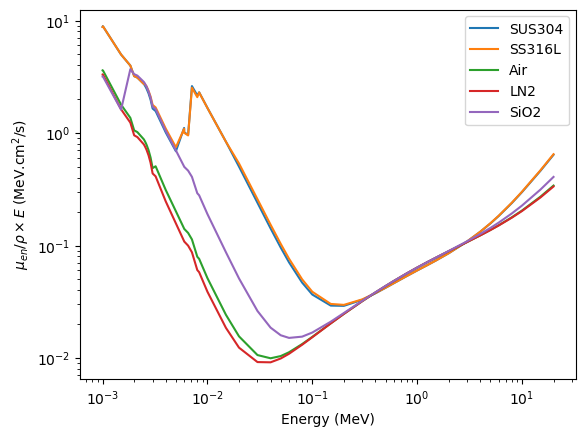

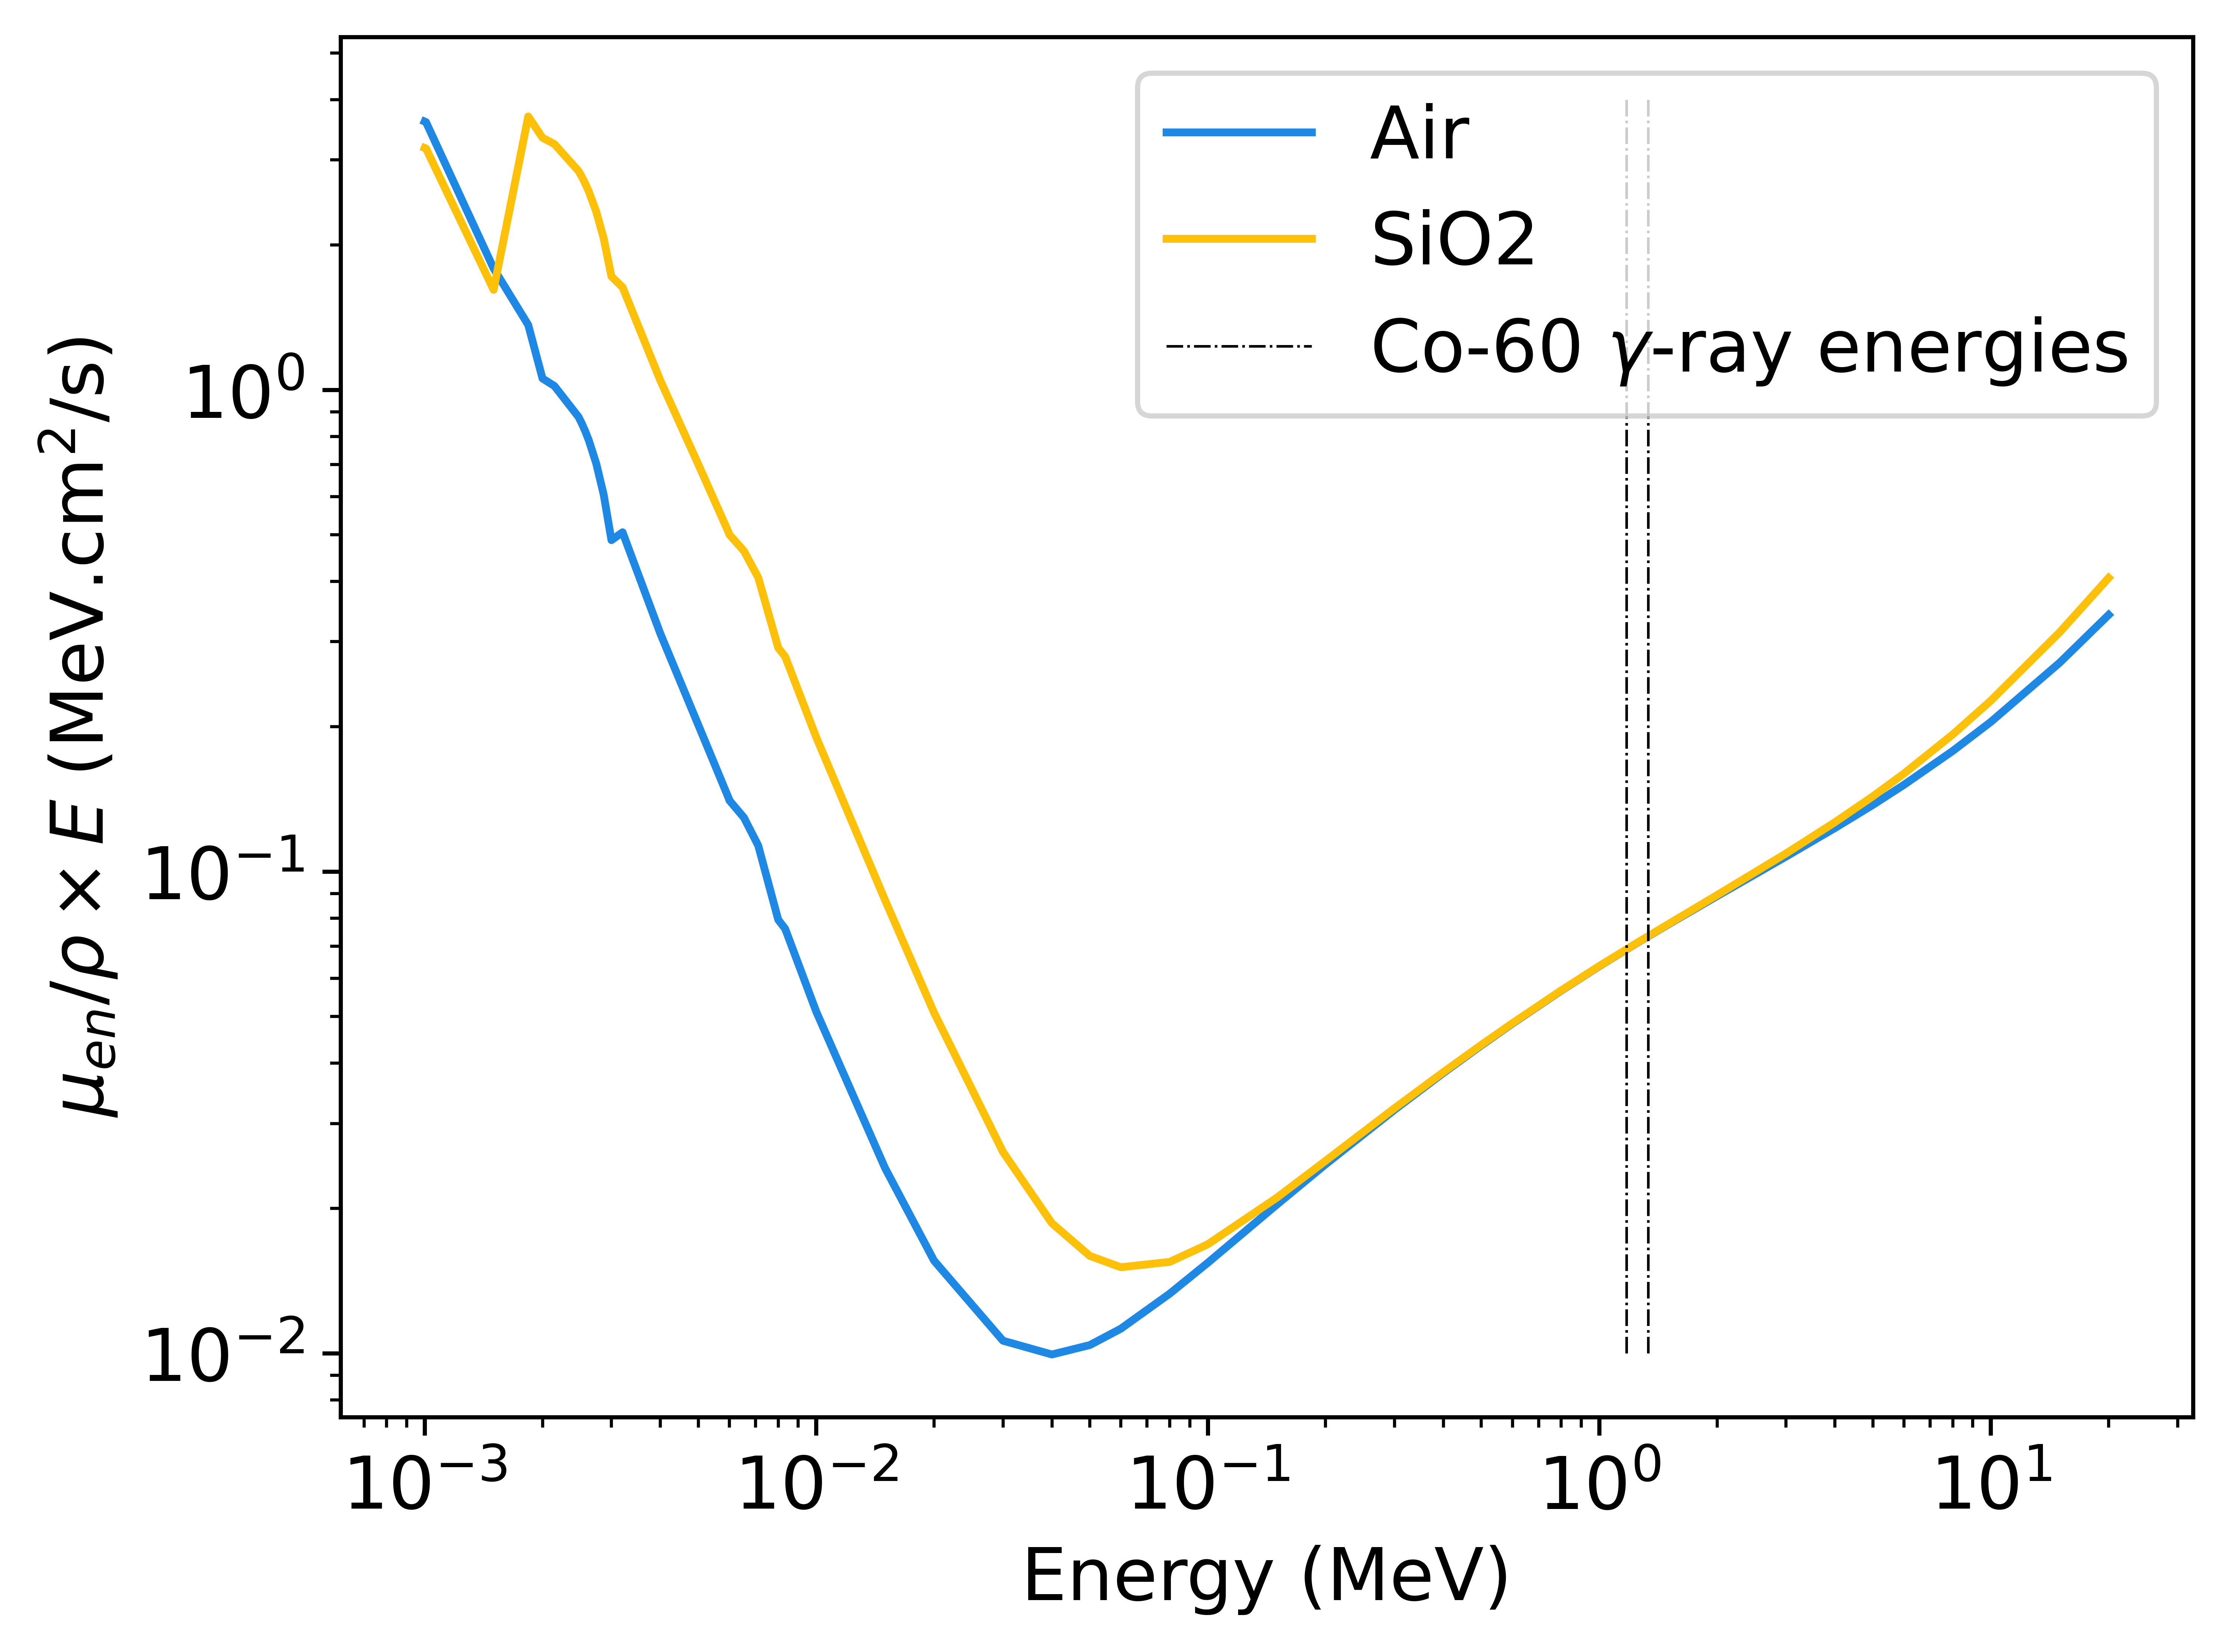

In [2]:
#%% Geometry and material definition

#Increase details
Sample_height = 1 #cm
Spool_height= 1.5*2.54 #cm
Chamber_height= 20.47 #cm
Source_height = 21.11 #cm
Source_pitchcirclediameter = 20.91 #cm
Nb_pencils=48
Diam_pencil=np.pi*Source_pitchcirclediameter/Nb_pencils #cm , estimated from gammacell manual,
                                                        #it seems that they occupy the whole circle

#Changes from model with dewar and spool to empty chamber
only_air_in_chamber = False
#Sample vertical position
# z_spool = 0
z_spool = -Chamber_height/2 + 2.54*(7.625-(6.75-2)) #z coordinate of the center of the spool and of the
                                                    #center of the dose rate calculation cell
                                                    #(origin is center of the chamber)
print(z_spool)
#Liquid N2 level
z_ln2 = -Chamber_height/2 + 2.54*(7.625-3) #z coordinate of the ln2 surface level
# z_ln2 = +Chamber_height/2 - 1e-3 #if filled with LN2
# z_ln2 = z_spool + Spool_height/2 #if filled with LN2


#GENERAL PARAMETERS
C0=667.5e12 #Bq : total source activity
ENERGIES = [1.1732,1.3325] #MeV


#GEOMETRY
inwallD=5.5 #in
ouwallD=5.81 #in
inwallth=0.04 #in (between 0.020" and 0.060")
ouwallth=0.065 #in (between 0.030" and 0.100")
vacuumgap = (ouwallD-inwallD)/2 - inwallth - ouwallth #in (between 0.040" and 0.200")
print(f"The vacuum gap is {vacuumgap} inches. It is supposed to be between 0.040in and 0.200in")
###################################

radiusforevalofcentraldoserate = 0.2*2.54 #cm

RADII =    [3.4/2   ,3.7/2,4/2     ,inwallD/2,inwallD/2+inwallth,ouwallD/2-ouwallth,ouwallD/2,6.1/2] #in
print(f"Layers (r in in.) : {RADII}")
RADII = [2.54*r for r in RADII] #cm
MATERIAL = ["SS316L","Air","SS316L","LN2","SUS304","Vacuum","SUS304" ,"Air"]


FIBER = {"r_f":3.55/2*2.54, #cm
          "mat":"SiO2"}

# MATERIAL
Dic_Density ={ #g/cc  #Hypothesis: to conserve mass, we choose to set the density at ambiant temperature
                      #density, because the geometry corresponds to ambiant temperature geometry
    "SS316L":8.00, # https://matweb.com/search/DataSheet.aspx?
                    #MatGUID=a2d0107bf958442e9f8db6dc9933fe31&ckck=1
    "Air":1.204e-3, # https://www.princeton.edu/~maelabs/hpt/mechanics/mecha_36.htm#:
                     #~:text=Air%20at%20atmospheric%20pressure%20(1.013,of%201.204%20kg%2Fm3.
    "LN2":0.808, # https://lasers.colostate.edu/wp-content/uploads/2019/04/Cryogenic-Safety-Manual.pdf
    "SUS304":8.00, # https://matweb.com/search/DataSheet.aspx?MatGUID=abc4415b0f8b490387e3c922237098da
    "Vacuum":1.204e-3*1e-6, #We replace vacuum by low pressure air (1e-6)
    "SiO2":2.2, # (roughly) https://www.sciencedirect.com/topics/
                            #earth-and-planetary-sciences/silica-glass
    }

OinCO2=2*15.999/(12.011+2*15.999)
CinCO2=12.011/(12.011+2*15.999)
print(OinCO2,CinCO2)

Weight_fractions={
    "SUS304":{"Cr":19/100,
              "Ni":9.25/100,
              "Mo":0,
              "C":0.04/100,
              "Mn":1/100,
              "P":0.0225/100,
              "S":0.015/100,
              "Si":0.5/100,
              "N":0,
              "Fe":70.1725/100}, #https://matmatch.com/learn/material/sus304-stainless-steel-ss304
    "SS316L":{"Cr":17/100,
              "Ni":12/100,
              "Mo":2.5/100,
              "C":0.015/100,
              "Mn":1/100,
              "P":0.0225/100,
              "S":0.015/100,
              "Si":0.375/100,
              "N":0.05/100,
              "Fe":67.0225/100}, #https://www.sandmeyersteel.com/images/316-316l-317l-spec-sheet.pdf
    "Air":{"N":75.511/100,
           "O":23.14/100 + OinCO2*0.063/100,
           "Ar":1.29/100,
           "C":CinCO2*0.063/100}, #Last ones ignored in https://www.engineeringtoolbox.com/
                                                        #air-composition-d_212.html
    "LN2":{"N":1},
    "SiO2":{"O":0.532565,"Si":0.467435},
    #"Vacuum":{} We replace vacuum by low pressure air
    "Vacuum":{"N":75.511/100,
           "O":23.14/100 + OinCO2*0.063/100,
           "Ar":1.29/100,
           "C":CinCO2*0.063/100}, #Last ones ignored in
                                #https://www.engineeringtoolbox.com/air-composition-d_212.html
    # "Si":{"Si":1},
    }

#Renormalize to 1 for Air
sair=np.sum(list(Weight_fractions["Air"].values()))
for elem in Weight_fractions["Air"].keys():
    Weight_fractions["Air"][elem]/=sair

#Check that all weight fractions add up to 1 for each material
for mat in Weight_fractions.keys():
    s=np.sum(list(Weight_fractions[mat].values()))
    print(f"{mat} total :{s}")

#Mass energy absorption coefficient NIST XCOM
 #First, determine the most precise energy grid:
database='/home/aulegoup/Optical_fibers/GammaDoseRateCalc/NIST_XCOM_data'
ENERGYLIST=[]
for file in [f for f in os.listdir(database) if ".txt" in f]:
    with open(os.path.join(database,file),'r') as f:
        LINES= f.readlines()[1:]
        for l in LINES:
            e = float(l.split(' ')[0])
            if e not in ENERGYLIST:
                ENERGYLIST+=[e]
ENERGYLIST=np.sort(ENERGYLIST)

MassEnergyAbsCoeftimesE={}
for mat in Weight_fractions.keys():
    coefmat=np.zeros(len(ENERGYLIST))
    for elem in Weight_fractions[mat].keys():
        file=f"nist_{elem}.txt"
        with open(os.path.join(database,file),'r') as f:
            LINES= f.readlines()[1:]
            LINES=[l for l in LINES if '.' in l]
            Energies_elem, MUenRHO_elem = [float(l.split(' ')[0]) for l in LINES],[float(l.split(' ')[2]) for l in LINES]
        coefmat += Weight_fractions[mat][elem]*np.interp(ENERGYLIST, Energies_elem, MUenRHO_elem)
    MassEnergyAbsCoeftimesE[mat]=coefmat*ENERGYLIST

ENERGYLIST*=1e6

for mat in MassEnergyAbsCoeftimesE.keys():
    if mat!="Vacuum":
        plt.plot(ENERGYLIST/1e6,MassEnergyAbsCoeftimesE[mat],label=mat)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel("Energy (MeV)")
plt.ylabel(r"$\mu_{en}/\rho\times E$ (MeV.cm$^2$/s)")

save=False
if save:
    plt.savefig("MassEnergyAbsCoef.pdf", bbox_inches='tight')
else:
    plt.show()

#SECOND PLOT

plt.figure(dpi=1000)
COLORS = ["#1E88E5",
          "#FFC107"]
for i,mat in enumerate(["Air","SiO2"]):
    if mat!="Vacuum":
        plt.plot(ENERGYLIST/1e6,MassEnergyAbsCoeftimesE[mat],label=mat,color=COLORS[i])
plt.vlines(1.1732,1e-2,4e0,linewidth=0.5,color='k',linestyle='dashdot',label="Co-60 $\gamma$-ray energies")
plt.vlines(1.3325,1e-2,4e0,linewidth=0.5,color='k',linestyle='dashdot')
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=14)
plt.xlabel("Energy (MeV)",fontsize=14)
plt.ylabel(r"$\mu_{en}/\rho\times E$ (MeV.cm$^2$/s)",fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)

save=False
if save:
    plt.savefig("MassEnergyAbsCoef_RSI.pdf", bbox_inches='tight')
else:
    plt.show()

# Defining settings

In [3]:
print([99.85/(99.85+99.9826),99.9826/(99.85+99.9826)])

[0.49966822230206676, 0.5003317776979331]


In [4]:
settings = openmc.Settings()
#Photon source

SOURCES=[]
for theta in [2*np.pi*i/Nb_pencils for i in range(Nb_pencils)]:
    r_stat,phi_stat,z_stat = openmc.stats.Uniform(0.0,Diam_pencil/2),openmc.stats.Uniform(0.0, 2*np.pi),openmc.stats.Uniform(-Source_height/2, Source_height/2)
    SOURCES += [openmc.IndependentSource()]
    SOURCES[-1].space = openmc.stats.CylindricalIndependent(r_stat, phi_stat, z_stat, origin=(Source_pitchcirclediameter/2*np.cos(theta),Source_pitchcirclediameter/2*np.sin(theta), 0.0))
    SOURCES[-1].angle = openmc.stats.Isotropic()
    SOURCES[-1].energy = openmc.stats.Discrete([1.173228e6,1.332492e6], [99.85/(99.85+99.9826),99.9826/(99.85+99.9826)]) #https://pripyat.mit.edu/KAERI/cgi-bin/decay?Co-60%20B-
    SOURCES[-1].particle = 'photon'
    SOURCES[-1].strength = 1/Nb_pencils
settings.source = SOURCES

#Enable photon transport
settings.photon_transport = True

#Nb particles & batches
settings.batches = 200
settings.inactive = 0 # Not needed in fixed source simulation
settings.particles = 100000
settings.temperature = {'method': 'interpolation','range':(77,300)}
settings.verbosity = 5
settings.run_mode = 'fixed source'

#Entropy mesh
entropy_mesh = openmc.RegularMesh()
r_m=RADII[-1]+0.5
entropy_mesh.lower_left = (-r_m, -r_m)
entropy_mesh.upper_right = (r_m, r_m)
entropy_mesh.dimension = (8, 8)

settings.export_to_xml()

# Defining materials

In [5]:
Tcold=293.15
Tamb=295

#For each material, set name, id, temperature, density and composition
def addMaterial(id, name, temp, key):
    mat=openmc.Material(id,name,temperature=temp)
    WFdict=Weight_fractions[key]
    for elem in WFdict.keys():
        if elem=='C':
            mat.add_nuclide('C0',WFdict[elem],percent_type='wo')
        else:
            mat.add_element(elem,WFdict[elem],percent_type='wo')
    mat.set_density('g/cm3',Dic_Density[key])
    return mat

# SS316L
ss316l = addMaterial(1,"SS316L",Tcold,"SS316L")
# SiO2
sio2 = addMaterial(2,"SiO2",Tcold,"SiO2")
# LN2
ln2 = addMaterial(3,"LN2",Tcold,"LN2")
# SUS304 inside
sus304in = addMaterial(4,"SUS304_in",Tcold,"SUS304")
# Vacuum
vacuum = addMaterial(5,"Vacuum",Tamb,"Vacuum")
# SUS304 outside
sus304out = addMaterial(6,"SUS304_out",Tamb,"SUS304")
# Air
air = addMaterial(7,"Air",Tamb,"Air")

mats = openmc.Materials([ss316l,sio2,ln2,sus304in,vacuum,sus304out,air])
mats.cross_sections = '/home/aulegoup/openmc_config/endfb71_hdf5/cross_sections.xml'
mats.export_to_xml()

# Defining geometry

BoundingBox(lower_left=(-11.139279149860027, -11.139279149860027, -10.555000999999999), upper_right=(11.139279149860027, 11.139279149860027, 10.555000999999999))


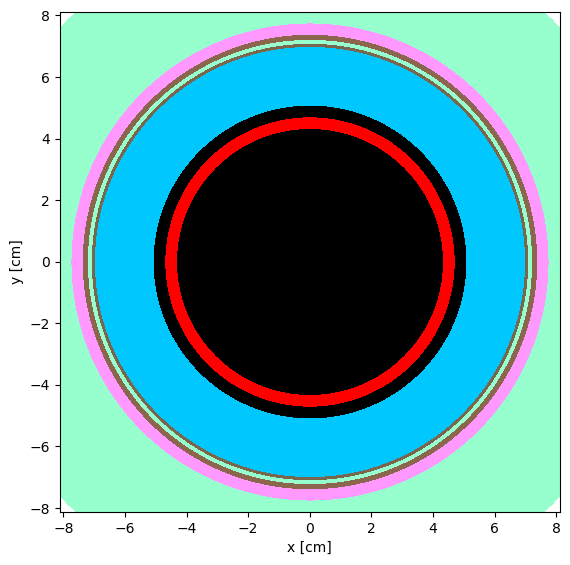

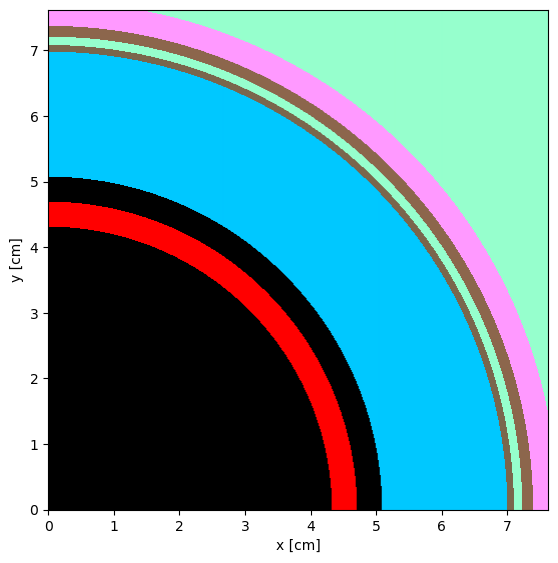

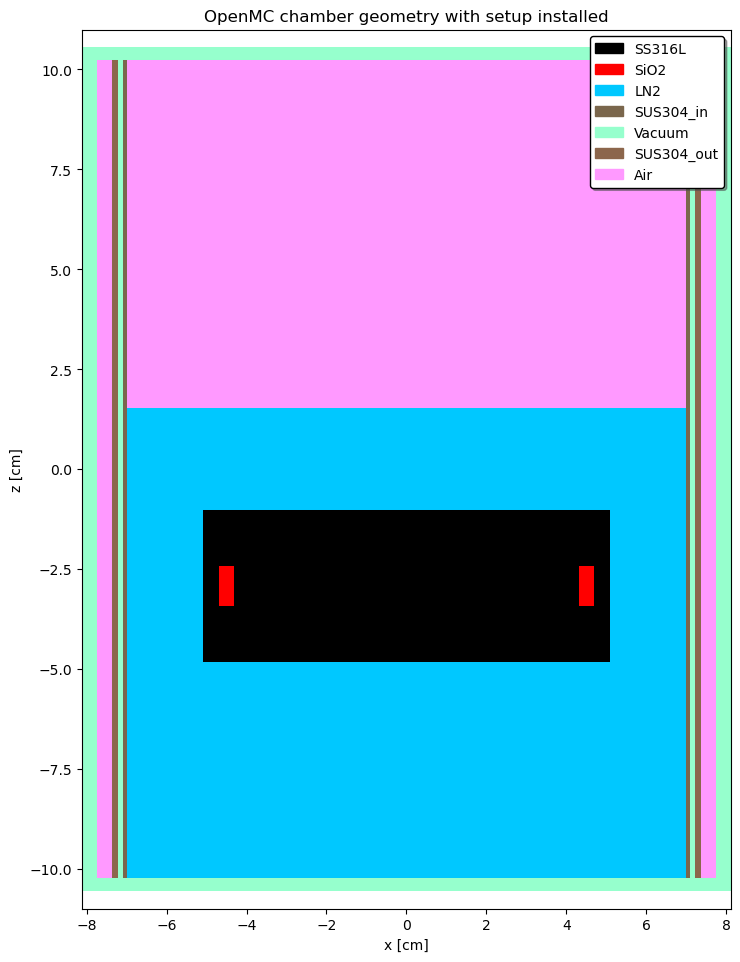

In [6]:
# Define the surfaces
CYLINDERS = [openmc.ZCylinder(r=R) for R in RADII[:]]+[openmc.ZCylinder(r=(Source_pitchcirclediameter+Diam_pencil)/2+1e-6,boundary_type='vacuum')]
CylCenterDReval = openmc.ZCylinder(r=radiusforevalofcentraldoserate)

LowPlane_sample = openmc.ZPlane(z0=z_spool-Sample_height/2)
HighPlane_sample = openmc.ZPlane(z0=z_spool+Sample_height/2)

LowPlane_spool = openmc.ZPlane(z0=z_spool-Spool_height/2)
HighPlane_spool = openmc.ZPlane(z0=z_spool+Spool_height/2)

HighPlane_ln2 = openmc.ZPlane(z0=z_ln2)

LowPlane_chamber = openmc.ZPlane(z0=-Chamber_height/2)
HighPlane_chamber = openmc.ZPlane(z0=Chamber_height/2)

LowPlane_model = openmc.ZPlane(z0=-Source_height/2-1e-6,boundary_type='vacuum')
HighPlane_model = openmc.ZPlane(z0=Source_height/2+1e-6,boundary_type='vacuum')

# Define the regions
centDReval_region = -CylCenterDReval & +LowPlane_sample & -HighPlane_sample
center_region    = +CylCenterDReval & -CYLINDERS[0] & +LowPlane_sample & -HighPlane_sample
sample_region    = +CYLINDERS[0] & -CYLINDERS[1] & +LowPlane_sample & -HighPlane_sample
outer316_region  = (+CYLINDERS[1] & -CYLINDERS[2] & +LowPlane_sample & -HighPlane_sample) | (-CYLINDERS[2] & +LowPlane_spool & -LowPlane_sample)  | (-CYLINDERS[2] & +HighPlane_sample & -HighPlane_spool) 
ln2_region       = (-CYLINDERS[3] & +LowPlane_chamber & -HighPlane_ln2) & ~(-CYLINDERS[2] & +LowPlane_spool & -HighPlane_spool)
airaboveln2_region = -CYLINDERS[3] & +HighPlane_ln2 & -HighPlane_chamber #NEW
sus304in_region  = +CYLINDERS[3] & -CYLINDERS[4] & +LowPlane_chamber & -HighPlane_chamber
vacuum_region    = +CYLINDERS[4] & -CYLINDERS[5] & +LowPlane_chamber & -HighPlane_chamber
sus304out_region = +CYLINDERS[5] & -CYLINDERS[6] & +LowPlane_chamber & -HighPlane_chamber
air_region       = +CYLINDERS[6] & -CYLINDERS[7] & +LowPlane_chamber & -HighPlane_chamber
extvacuum_region = (-CYLINDERS[8] & +LowPlane_model & -HighPlane_model) & ~(-CYLINDERS[7] & +LowPlane_chamber & -HighPlane_chamber)

# Make Cells and Fill
if not(only_air_in_chamber):
    centDReval_cell= openmc.Cell(10, 'centDReval', fill=ss316l, region=centDReval_region)
    center_cell    = openmc.Cell(1, 'center', fill=ss316l, region=center_region)
    sample_cell    = openmc.Cell(2, 'sample', fill=sio2, region=sample_region)
    outer316_cell  = openmc.Cell(3, 'outer316', fill=ss316l, region=outer316_region)
    ln2_cell       = openmc.Cell(4, 'ln2', fill=ln2, region=ln2_region)
    airaboveln2_cell = openmc.Cell(11, 'airaboveln2', fill=air, region=airaboveln2_region) #NEW
    sus304in_cell  = openmc.Cell(5, 'sus304in', fill=sus304in, region=sus304in_region)
    vacuum_cell    = openmc.Cell(6, 'vacuum', fill=vacuum, region=vacuum_region)
    sus304out_cell = openmc.Cell(7, 'sus304out', fill=sus304out, region=sus304out_region)
    air_cell       = openmc.Cell(8, 'air', fill=air, region=air_region)
    extvacuum_cell = openmc.Cell(9, 'extvacuum', fill=vacuum, region=extvacuum_region)
    
else:
    centDReval_cell= openmc.Cell(10, 'centDReval', fill=air, region=centDReval_region)
    center_cell    = openmc.Cell(1, 'center', fill=air, region=center_region)
    sample_cell    = openmc.Cell(2, 'sample', fill=air, region=sample_region)
    outer316_cell  = openmc.Cell(3, 'outer316', fill=air, region=outer316_region)
    ln2_cell       = openmc.Cell(4, 'ln2', fill=air, region=ln2_region)
    airaboveln2_cell = openmc.Cell(11, 'airaboveln2', fill=air, region=airaboveln2_region) #NEW
    sus304in_cell  = openmc.Cell(5, 'sus304in', fill=air, region=sus304in_region)
    vacuum_cell    = openmc.Cell(6, 'vacuum', fill=air, region=vacuum_region)
    sus304out_cell = openmc.Cell(7, 'sus304out', fill=air, region=sus304out_region)
    air_cell       = openmc.Cell(8, 'air', fill=air, region=air_region)
    extvacuum_cell = openmc.Cell(9, 'extvacuum', fill=vacuum, region=extvacuum_region)

DicVolCell={
10: Sample_height*np.pi*radiusforevalofcentraldoserate**2,
1 : Sample_height*np.pi*(RADII[0]**2-radiusforevalofcentraldoserate**2),
2 : Sample_height*np.pi*(RADII[1]**2-RADII[0]**2),
3 : Sample_height*np.pi*(RADII[2]**2-RADII[1]**2)+(Spool_height-Sample_height)*np.pi*RADII[2]**2,
4 : Spool_height*np.pi*(RADII[3]**2-RADII[2]**2)+(Chamber_height-Spool_height)*np.pi*RADII[3]**2 - (Chamber_height/2-z_ln2)*np.pi*RADII[3]**2,
11: (Chamber_height/2-z_ln2)*np.pi*RADII[3]**2,
5 : Chamber_height*np.pi*(RADII[4]**2-RADII[3]**2),
6 : Chamber_height*np.pi*(RADII[5]**2-RADII[4]**2),
7 : Chamber_height*np.pi*(RADII[6]**2-RADII[5]**2),
8 : Chamber_height*np.pi*(RADII[7]**2-RADII[6]**2),
9 : Chamber_height*np.pi*(((Source_pitchcirclediameter+Diam_pencil)/2+1e-6)**2-RADII[7]**2)
    +(Source_height+2e-6-Chamber_height)*np.pi*((Source_pitchcirclediameter+Diam_pencil)/2+1e-6)**2,
}


root = openmc.Universe(cells=(centDReval_cell,center_cell, sample_cell, outer316_cell, ln2_cell, sus304in_cell, vacuum_cell, sus304out_cell, air_cell,extvacuum_cell, airaboveln2_cell))
geom = openmc.Geometry(root)
geom.export_to_xml()

print(root.bounding_box)

#Plot the geometry
diccolors={ss316l:(0,0,0),
           sio2:(255,0,0),
           ln2:(0,200,255),
           sus304in:(122,102,76),
           vacuum:(150,255,205),
           sus304out:(140,102,76),
           air:(255,153,255)}
root.plot(origin=(0., 0., -3.), width=(6*2.54+1, 6*2.54+1), pixels=(500, 500), color_by='material',colors=diccolors)
root.plot(origin=(1.5*2.54, 1.5*2.54, -3), width=(3*2.54, 3*2.54), pixels=(500, 500),color_by='material',colors=diccolors)
root.plot(origin=(0., 0., 0.), width=(6*2.54+1, 22), basis='xz', color_by='material',colors=diccolors, pixels=(int((6*2.54+1)*40), 22*40))

from matplotlib.patches import Patch
legend_elements = []
for mat in mats:
    # print(mat.name)
    MatIsHere = mat in [V.fill for V in root.cells.values()]
    if MatIsHere:
        colr = tuple([i/255 for i in diccolors[mat]])
        legend_elements += [Patch(facecolor=colr, edgecolor=colr,label=mat.name)]
plt.legend(handles=legend_elements, loc='best', shadow=True, facecolor="white", edgecolor="black",framealpha=1)
if not(only_air_in_chamber):
    plt.title("OpenMC chamber geometry with setup installed")
else:
    plt.title("OpenMC empty chamber geometry")

save=False
if save:
    if not(only_air_in_chamber):
        plt.savefig("OpenMC_geom_full.pdf", bbox_inches='tight')
    else:
        plt.savefig("OpenMC_geom_empty.pdf", bbox_inches='tight')
else:
    plt.show()

In [7]:
for mat in mats:
    print(mat.name)
    print(mat in [V.fill for V in root.cells.values()])

SS316L
True
SiO2
True
LN2
True
SUS304_in
True
Vacuum
True
SUS304_out
True
Air
True


# Define the Tallies

In [8]:
def get_var_name(var):
    for name, value in globals().items():
        if value is var:
            return name

for cell in [centDReval_cell,center_cell, sample_cell, outer316_cell,ln2_cell, sus304in_cell, vacuum_cell, sus304out_cell, air_cell,extvacuum_cell]:
    print(get_var_name(cell),'\t', cell.fill.name.split('_')[0])

centDReval_cell 	 SS316L
center_cell 	 SS316L
sample_cell 	 SiO2
outer316_cell 	 SS316L
ln2_cell 	 LN2
sus304in_cell 	 SUS304
vacuum_cell 	 Vacuum
sus304out_cell 	 SUS304
air_cell 	 Air
extvacuum_cell 	 Vacuum


In [ ]:
tallies_file = openmc.Tallies()

particle_filter = openmc.ParticleFilter('photon')

#energy, dose = openmc.data.dose_coefficients('photon kerma', 'ISO')
#dose_filter = openmc.EnergyFunctionFilter(energy, dose)
#ENERGYLIST,MassEnergyAbsCoeftimesE[mat]
DOSETALLIES=[]
for cell in [centDReval_cell,center_cell, sample_cell, outer316_cell,ln2_cell, sus304in_cell, vacuum_cell, sus304out_cell, air_cell,extvacuum_cell,airaboveln2_cell]:
    name=get_var_name(cell)
    mat=cell.fill.name.split('_')[0]
    dose_filter = openmc.EnergyFunctionFilter(ENERGYLIST,MassEnergyAbsCoeftimesE[mat])
    cell_filter = openmc.CellFilter(cell)
    DOSETALLIES += [openmc.Tally(name=f"Photon dose tally - cell {name}")]
    DOSETALLIES[-1].filters = [particle_filter,dose_filter,cell_filter]
    DOSETALLIES[-1].scores = ['flux']
    tallies_file.append(DOSETALLIES[-1])

FluxCylTally = openmc.Tally(name="Photon total flux - cylindrical mesh")
r_grid=np.linspace(0.0, (Source_pitchcirclediameter+Diam_pencil)/2, 100)
cylindrical_mesh = openmc.CylindricalMesh(r_grid = r_grid,
                                         phi_grid = [0.0, 2*np.pi],
                                         z_grid = [z_spool-Sample_height/2, z_spool+Sample_height/2])
cylindrical_mesh_filter = openmc.MeshFilter(cylindrical_mesh)
FluxCylTally.filters = [particle_filter,cylindrical_mesh_filter]
FluxCylTally.scores = ['flux']
tallies_file.append(FluxCylTally)

samplecell_filter = openmc.CellFilter(sample_cell)
energies = np.logspace(np.log10(1e-5), np.log10(2.0e6), 100000)
e_filter = openmc.EnergyFilter(energies)
fluxtally = openmc.Tally(name="Photon flux tally")
fluxtally.filters = [particle_filter,e_filter]
fluxtally.scores = ['flux']
tallies_file.append(fluxtally)

tallies_file.export_to_xml()

# Run OpenMC

In [10]:
openmc.run()

sp = openmc.StatePoint(f'statepoint.{settings.batches}.h5')

# os.remove('geometry.xml')
# os.remove('materials.xml')
# os.remove('settings.xml')
# os.remove('statepoint.100.h5')
# os.remove('summary.h5')
# del sp

[ASUS-Aurlien:208294] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%

In [11]:
if not(only_air_in_chamber):
    print("For the 3D model with dewar and fiber sample :\n")
else:
    print("For an empty chamber (only air):\n")

print(f"z_spool = {z_spool:.2f} cm\n")

for cell in [centDReval_cell,center_cell, sample_cell, outer316_cell,ln2_cell, sus304in_cell, vacuum_cell, sus304out_cell, air_cell,extvacuum_cell,airaboveln2_cell]:
    name=get_var_name(cell)
    mat=cell.fill.name
    tally=sp.get_tally(name=f"Photon dose tally - cell {name}").get_pandas_dataframe()
    tallyvalue = ufloat(tally.get("mean").loc[0],tally.get("std. dev.").loc[0]) *C0/DicVolCell[cell.id] *1.6022e-10 *3600/1000 
    print(f"Cell {name} ({mat}) : {tallyvalue:.2f} kGy/h")

For the 3D model with dewar and fiber sample :

z_spool = -2.93 cm

Cell centDReval_cell (SS316L) : 6.08+/-0.08 kGy/h
Cell center_cell (SS316L) : 7.87+/-0.02 kGy/h
Cell sample_cell (SiO2) : 11.02+/-0.03 kGy/h
Cell outer316_cell (SS316L) : 9.32+/-0.01 kGy/h
Cell ln2_cell (LN2) : 13.14+/-0.01 kGy/h
Cell sus304in_cell (SUS304_in) : 15.48+/-0.01 kGy/h
Cell vacuum_cell (Vacuum) : 16.59+/-0.01 kGy/h
Cell sus304out_cell (SUS304_out) : 16.34+/-0.01 kGy/h
Cell air_cell (Air) : 18.51+/-0.01 kGy/h
Cell extvacuum_cell (Vacuum) : 29.85+/-0.01 kGy/h
Cell airaboveln2_cell (Air) : 14.63+/-0.01 kGy/h


['particle', 'energy low [eV]', 'energy high [eV]', 'nuclide', 'score', 'mean', 'std. dev.']


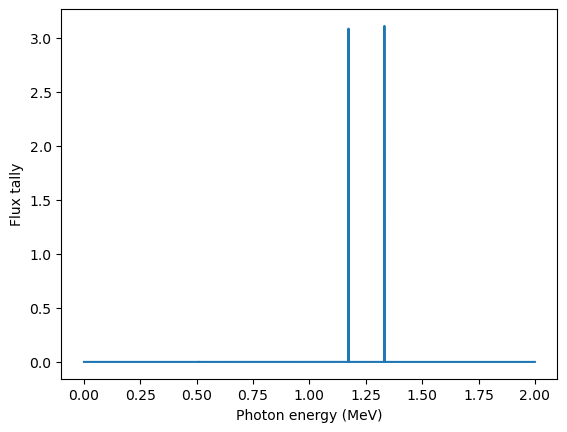

In [12]:
tally=sp.get_tally(name="Photon flux tally").get_pandas_dataframe()
print(list(tally.columns))
energy_low,energy_high,flux = np.array(tally["energy low [eV]"]),np.array(tally["energy high [eV]"]),np.array(tally["mean"])
plt.plot((energy_low+energy_high)/2e6,flux)
plt.xlabel("Photon energy (MeV)")
plt.ylabel("Flux tally")
plt.show()

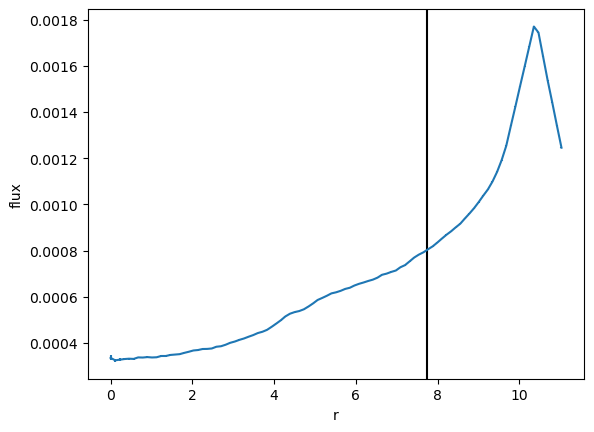

Ratio between flux at chamber wall and flux at center : 240+/-7 %


In [13]:
tally=sp.get_tally(name="Photon total flux - cylindrical mesh").get_pandas_dataframe()
# print(r_grid)
flux=np.array([ufloat(m,s) for m,s in zip(tally.get('mean').tolist(),tally.get('std. dev.').tolist())])
flux /= Sample_height*np.pi*(r_grid[1:]**2-r_grid[:-1]**2) 
# print(flux)
plt.errorbar(r_grid[:-1],[f.n for f in flux], yerr=[f.s for f in flux])
plt.axvline(x=6.1/2*2.54,color='k')
plt.xlabel('r')
plt.ylabel('flux')
plt.show()
atwall=next(flux[x] for x,val in enumerate(r_grid) if val>6.1/2*2.54)
print(f"Ratio between flux at chamber wall and flux at center : {atwall/flux[0]*100} %")